# Combined Kriging Class

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy.stats
from scipy import spatial
from scipy import optimize
from scipy import special
from skimage import measure
from scipy import sparse
from scipy.sparse.linalg import splu
import time
from scipy.spatial.distance import cdist

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Kriging(object):
    # What do I want: 
    # passing: Data with properties, layer, geo_data --> meaning that I have to cut everything in here! - check
    # --- this is basically done 
    # possibility to read in data - check gempy how to do best
    # --- if data has own xyz coordinates I need to fit them to grid
    # analyzing data part needs to be in here somewhere, have to check how "OK" that is,
    # --- includes histogram and variogram building as well as fitting a function and converting to covariance function
    # --- and if I can switch between covariance function (SK) and variogram function (OK, UK) in a reasonable manner
    # Selection:
    # SK, OK, UK
    # --- SK needs covariance function instead of variogram function - check
    # --- UK needs completely different setup as I need the coordinates of eacht point in Kriging matrices - check
    # cdist or my distance
    # --- need to set up my distance calculation properly also maybe with several planes as suggested by Florian
    # SGS or not?
    def __init__(self, data, geomodel, geodata, formation_number, kriging_type=None, distance_type=None, variogram_model=None):
        # here I want to put the basic variables and also the data analysis - or maybe even everything?!
        
        self.geomodel = geomodel
        self.grid = geodata.grid
        self.formation_number = formation_number
        self.data = data
        self.extent = geodata.extent
        self.resolution = geodata.resolution
        
        # control parameters
        self.neg_var_count = 0
        self.control_coord = np.zeros((1,3))
        
        # Basic input data parameters for SK 
        self.inp_mean = np.mean(data['Property'])
        self.inp_var = np.var(data['Property'])
        self.inp_std = np.sqrt(self.inp_var)
        
        # Set default Kriging type to OK
        if kriging_type is None:
            kriging_type = 'OK'
        self.kriging_type = kriging_type
        
        # Set default distance type to euclidian
        if distance_type is None:
            distance_type = 'euclidian'
        self.distance_type = distance_type
        
        # Set default distance type to euclidian
        if variogram_model is None:
            variogram_model = 'exponential'
            self.variogram_model = variogram_model
        
        t_init1 = time.time()
        #PART 1: Initializing data and domain
        # set domain data
        self.grid_dataframe = self.init_domain()
        # set property data (finally needs to be an 2d array with index in grid_dataframe and value)
        self.property_data = self.match_data_positions() #hier schraube ich gerade
        t_init2 = time.time()
        print("initializing:", t_init2-t_init1)
        
        #PART 2: Analyzing the data - mainly getting a variogram/covariance function 
        # best case, only do that if not done before, so only of nothing is specified in keywords
        # preset everything for now, maybe make this optional later, either pass sill, range, model, and nugget
        # or make scipy bestfit
        self.range_ = 169
        self.sill = 38
        self.nugget = 1
        
        #PART 3: Acutally performing Kriging 
        self.kriging_result, self.result_coord = self.sgs() 
        
    
    #def get_data():
        # method to read data from given csv and create pandas dataframe
        # question if this is really necessary, or if passing a pandas dataframe is sufficient
        
    def init_domain (self):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        reduced to a certain formation of interest. Thus as of now, Kriging is only possible within one layer of the
        model. Allowing multiple layers or the whole model should not be too difficult if required.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation_number (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, meaning xyz of each grid point.
        """
    
        # convert lith block values to int, thats what Miguel suggested --> maybe a better solution required
        geomodel_int = np.round(self.geomodel[0])
        scalar_field_value = self.geomodel[1]
    
        # create the dataframe and populate with data
        d = {'X': self.grid.values[:,0], 'Y': self.grid.values[:,1], 'Z': self.grid.values[:,2], 'lith': geomodel_int, 'scalar': scalar_field_value}
        dataframe_aux = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        grid_dataframe = dataframe_aux.loc[dataframe_aux['lith'] == self.formation_number]
        grid_dataframe = grid_dataframe.reset_index() # reset indicies
        del grid_dataframe['index'] # reset indices

        return grid_dataframe
    
    def match_data_positions(self):
        '''
        Method to match XYZ coordinates of measured property data to grid points, as distances are computed 
        grid points. Right now also points outside the specified domain are projected onto the grid. Maybe add
        if clause for greater distances.
        Args:
            data (pandas.dataframe): dataframe containing xyz coordinates and property values
            grid_dataframe: containing xyz of grid coordinates
        Returns
            data_pos(np.array)(2,n) = array containing grid index [0] and corresponding property value [1]
            '''
        # extracting required data
        prop_coord = self.data.as_matrix(('X','Y','Z'))
        values = self.data.as_matrix(('Property',))
        #coord3d = np.delete(self.grid_dataframe.values, 3, 1)
        coord3d = self.grid_dataframe.as_matrix(('X','Y','Z'))
        
        # empty aray for results
        data_pos = np.zeros((len(values), 2))
       
        # finding closest grid point for each data value
        for i in range (len(self.data)):
            closest = np.argmin(cdist(prop_coord[i].reshape(1,3), coord3d))
            data_pos[i][0]= closest
            data_pos[i][1]= values[i]
        
        # workaround for rounding - hast to be optimized
        data_pos = data_pos.astype(int)
        data_pos = np.swapaxes(data_pos,0,1)
        
        return data_pos
    
            #def analyse_data():
        # method for getting mean, std, etc. of the given dataset
        
    def precalculate_distances(self, prop_data, sgs_check, grid_coord):
        
        # order grid by indices given in prop_data[0] and sgs check
        aux = np.append(prop_data[0], sgs_check)
        grid_reordered = grid_coord[aux]
        
        if self.distance_type == 'euclidian':
            # perform cdist - easy and fast for straight distances
            dist_matrix = cdist(grid_reordered, grid_reordered)
        elif self.distance_type == 'deformed':
            dist_matrix = self.dist_all_to_all(grid_reordered)
            
        return dist_matrix, grid_reordered
    
    def dist_all_to_all(self, grid_reordered):
        # 1: Calculte central average plane within domain between top and bottom border
        med_ver, med_sim, grad_plane = self.create_central_plane()
        # 2: project each point in domain on this plane (by closest point) and save this as reference point
        ref, perp = self.projection_of_each_point(med_ver, grad_plane, grid_reordered)
        # 3: Calculate distances on reference plane by heat method
        dist_clean = self.proj_surface_dist_each_to_each(med_ver, med_sim)
        # 4: Combine results to final distance matrix, here i should set stretch factors
        dist_matrix = self.distances_grid(ref, perp, dist_clean)

        return dist_matrix
    
    def create_central_plane(self):
        # find highest and lowest scalar field value (top and bot layer)
        grad_top = np.max(self.grid_dataframe.scalar)
        grad_bot = np.min(self.grid_dataframe.scalar)
        # do precalculations, mesh through basic point (only once)
        a = self.geomodel[1].reshape(self.resolution)
        grad = (grad_top+grad_bot)/2

        vertices, simplices, normals, values = measure.marching_cubes_lewiner(
                a,
                grad,
                step_size=1,
                spacing=((self.extent[1]/self.resolution[0]),(self.extent[3]/self.resolution[1]),(self.extent[5]/self.resolution[2])))

        return vertices, simplices, grad
    
    def projection_of_each_point(self, ver, plane_grad, grid_reordered):
    
        grid = grid_reordered[:,:3]
        # create matrix from grid data, as well as empty array for results
        # grad_check = self.grid_dataframe.as_matrix(('scalar',))[:,0] # old version
        grad_check = grid_reordered[:,4] # new version, seems to be equivalent
        grad_check = grad_check > plane_grad
        ref = np.zeros(len(grid))
        perp = np.zeros(len(grid))

        # loop through grid to refernce each point to closest point on reference plane by index
        for i in range(len(grid)):
            ref[i] = cdist(grid[i].reshape(1,3), ver).argmin()
            # get the cdistance to closest point and save it
            perp[i] = cdist(grid[i].reshape(1,3), ver).min()

        # reshape perp to make values either negative or positive (depending on scalar field value)
        # there has to be an easier way to do it with the a mask
        for i in range(len(perp)):
            if grad_check[i]==True:
                perp[i]=perp[i]*(-1)

        return ref, perp
    
    def proj_surface_dist_each_to_each(self, med_ver, med_sim):
    
        # precomputing 
        compute_distance = GeodesicDistanceComputation(med_ver, med_sim)

        # create empty matrix
        dist = np.zeros([len(med_ver), len(med_ver)])

        for i in range(len(med_ver)):
            # distance calculation
            dist[i] = compute_distance(i)
        
        # operation to take average of dist, as heat method is not exact
        dist_clean = (dist+dist.T)/2

        return dist_clean
    
    def distances_grid(self, ref, perp, dist_clean):
        # stretch factor test, does not work with variogram model like this
        #dist_clean = dist_clean/100
    
        dist_matrix = np.zeros([len(ref), len(ref)])
        ref = ref.astype(int)

        for i in range(len(ref)):
            for j in range(len(ref)):
                dist_matrix[i][j]=dist_clean[ref[i]][ref[j]]+abs(perp[i]-perp[j])

        # algorithm is not optimal for short distances, thus putting them to minium possible cdist value for resolution
        # seems very reasonable, here that is 25
        # dist_matrix[dist_matrix < 25] = 25
        np.fill_diagonal(dist_matrix, 0)

        return dist_matrix
    
    def gaussian_variogram_model(self, d):
        psill =self.sill-self.nugget
        gamma = psill * (1. - np.exp(-d**2./(self.range_)**2.))+self.nugget
        return gamma
    
    def gaussian_covariance_model(self, d):
        # variance normed to values
        self.sill = self.inp_var/self.inp_mean
        gamma = self.sill * (np.exp(-d**2./(self.range_)**2.))
        return gamma
    
    def exponential_variogram_model(self, d):
        psill =self.sill-self.nugget
        gamma = psill * (1. - np.exp(-(np.absolute(d)/(self.range_))))+self.nugget
        return gamma

    def simple_kriging(self, a, b, prop):
        
        # !!! SK still needs work: result only works with diagonal (nugget effect???) fill of 10 and covariance 
        # function seems more than shady ... but choosing kriging type works for all three options now
        # Also SGS does only work with scale = 0 so does not really wor at all :/

        # empty matrix buildung
        shape = len(a)
        C = np.zeros((shape, shape))
        c = np.zeros((shape))
        w = np.zeros((shape))

        # Faster matrix building approach, no loops
        C[:shape, :shape] = self.gaussian_covariance_model(b)
        c[:shape] = self.gaussian_covariance_model(a)

        # nugget effect
        np.fill_diagonal(C, 10)

        w = np.linalg.solve(C,c)

        # SGS version - taking result from normal distribution with kriging mean an standard deviation
        #result = np.random.normal(inp_mean + np.sum(w * (prop-inp_mean)), scale = 0) #scale=np.sqrt(variance-np.sum(w*c)))
        # if I use other scale it gets wild

        # direct version, calculating result from weights. Need to be normed to one
        result = self.inp_mean + np.sum(w * (prop-self.inp_mean))

        return result

    def ordinary_kriging(self, a, b, prop, target):
        
        # empty matrix building
        shape = len(a)
        C = np.zeros((shape+1, shape+1))
        c = np.zeros((shape+1))
        w = np.zeros((shape+1))

        if self.variogram_model == 'gaussian':
            # Faster matrix building approach, no loops
            C[:shape, :shape] = self.gaussian_variogram_model(b)
            c[:shape] = self.gaussian_variogram_model(a)
        elif self.variogram_model == 'exponential':
            # Faster matrix building approach, no loops
            C[:shape, :shape] = self.exponential_variogram_model(b)
            c[:shape] = self.exponential_variogram_model(a)
        elif self.variogram_model == 'spherical':
            print('not yet implemented')
        else:
            print('Variogram model not understood')

        # matrix setup - compare pykrige, special for OK
        np.fill_diagonal(C, 0) # is that OK?
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0  
        c[shape] = 1.0
            
        # Solve Kriging equations
        w = np.linalg.solve(C,c)

        # correcting for negative weights:
        #w_cor = w[:shape]
        #w_cor[w_cor < 0] = 0
        #w_cor = (w_cor/np.sum(w_cor))
        
        # SGS version - need to get mean and std
        #pred_var = w[shape]+np.sum(w_cor*c[:shape]) # for corrected weights
        pred_var = w[shape]+np.sum(w[:shape]*c[:shape])
        
        # count for negative variances for security, seems to be solved by using exponential
        if pred_var <= 0:
            # result = np.sum(w_cor * prop)
            # control mechanism
            self.neg_var_count = self.neg_var_count + 1
            # self.control_coord = np.vstack((self.control_coord, target[:3]))
        
        #result = np.random.normal(np.sum(w_cor  * prop), scale=np.sqrt(pred_var)) # code for corrected weights
        
        result = np.random.normal(np.sum(w[:shape]  * prop), scale=np.sqrt(pred_var))
        
        # direct version, calculating result from weights.
        # result = np.sum(w_cor * prop)

        return result
    
    def universal_kriging(self, a, b, prop, coord, target_coord):

        # empty matrix building
        shape = len(a)
        C = np.zeros((shape+1, shape+1))
        c = np.zeros((shape+1))
        w = np.zeros((shape+1))

        # Faster matrix building approach, no loops
        C[:shape, :shape] = self.gaussian_variogram_model(b)
        c[:shape] = self.gaussian_variogram_model(a)

        # matrix setup - compare pykrige
        np.fill_diagonal(C, 0) # is that OK
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0  
        c[shape] = 1.0

        # additional matrices for universal kriging, containing Coordinates and zeros
        aux1 = np.vstack((coord[:,:3], np.zeros((1, 3))))
        aux2 = np.hstack((np.transpose(coord[:,:3]), np.zeros((3,4))))

        # adding auxiliary matrices to the kriging matrices
        C = np.hstack((C, aux1))
        C = np.vstack((C, aux2))
        c = np.hstack((c, target_coord[:3]))

        # Solve Kriging equations
        w = np.linalg.solve(C,c)

        # SGS version - in UK case the scale (standard deviation) is not yet implemented/correct
        #result = np.random.normal(np.sum(w[:shape] * data_v), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))

        # direct version, calculating result from weights.
        result = np.sum(w[:shape] * prop)

        return result
    
    def get_distance_matrices(self, dist_matrix, n, prop_data, subcoord):
        """
        Method to get closest points out of distance matrix calculated beforehand.
        Args:
            dist_matrix (np.array): matrix of distances between existing property data points
            n(int): number of closest points used 
            prop_data(np.array)(n,2): array containing indexes of property data in grid and corresponding values
        Returns
            dist_close_all_to_all (n,n): matrix of distances between all selected closest points
            dist_close_target_to_all (n,): distances between target point and selected closest points
        """
        # condition if less data points are available # does work for anything but exactly one input point - SGS field
        if len(dist_matrix)-1 < n:
            n = len(dist_matrix)-1
        
        #index of target point, follows growth of dist matrix, as randomization is done before
        target_point = len(dist_matrix)-1

        # check for n closest points in matrix (minimum distance values) and sort the resulting index array
        # ind = np.argpartition(dist_matrix[target_point], n+1)[:n+1] # this was first (wrong?) way
        ind = np.argpartition(dist_matrix[target_point], n)[:n]
        sort_ind = np.sort(ind)

        # create new property array to match property data to correct indices
        ind_aux_prop = sort_ind[:len(sort_ind)-1]
        closest_prop_data = prop_data[1][ind_aux_prop]
        
        # only for UK also match coordinates
        closest_coord_data = subcoord[ind_aux_prop]

        # extract distances from target point (row of target index - now last row of matrix) without last entry (target)
        dist_close_target_to_all = dist_matrix[target_point][sort_ind]
        dist_close_target_to_all = dist_close_target_to_all[:len(dist_close_target_to_all)-1]

        # extract distance each to each for those closest points, delete target point index row and column
        dist_close_all_to_all = dist_matrix[np.ix_(sort_ind[:len(sort_ind)-1],sort_ind[:len(sort_ind)-1])]
        
        return dist_close_target_to_all, dist_close_all_to_all, closest_prop_data, closest_coord_data

    def sgs(self):
        
        # copy data to leave original data unchanged
        # grid_coord = self.grid_dataframe.values[:, :-1]
        grid_coord = self.grid_dataframe.values[:, :]
        prop_data = self.property_data
    
        # just for progress bar
        runs = len(grid_coord)-len(prop_data[0])

        # for timing purposes
        time_prec = 0
        time_sub = 0
        time_dist = 0
        time_krig = 0

        # create array to go through SGS, only containing indices of grid points without data
        sgs_check = np.arange(0,len(grid_coord))
        sgs_check = np.delete(sgs_check, prop_data[0])
    
        # randomize it to predefine SGS way
        np.random.shuffle(sgs_check)

        # precalculate distances in matrix and sgs order, as well as coordinates in sgs order (for UK only)
        t_pre1 = time.time()
        dist_matrix_sgs_order, coord_sgs_order = self.precalculate_distances(prop_data, sgs_check, grid_coord)
        t_pre2 = time.time()
        print("distance precalculation:", t_pre2-t_pre1)
        
        #self.plot_distances(dist_matrix_sgs_order, coord_sgs_order)

        # set initial length of property data frame
        start = len(prop_data[0])

        for i in range(0, len(sgs_check)):

            # choose first point from sgs_check, as this is already randomized
            target_point = sgs_check[i]
            # for UK coordinate of target point
            target_coord = grid_coord[sgs_check[i]]

            t0 = time.time()
            # extract submatrix required for distances, containing only grid points with property values
            submatrix = dist_matrix_sgs_order[0:start+i+1,0:start+i+1] 
            
            # for UK only to transfer coordinates:
            subcoord = coord_sgs_order[0:start+i+1]

            t1 = time.time()
            time_sub = time_sub+(t1-t0)
            # get closest distances
            # a, b, prop = self.get_distance_matrices(submatrix, 50, prop_data)
            # for UK version:
            a, b, close_prop, close_coord = self.get_distance_matrices(submatrix, 20, prop_data, subcoord)
                
            t2 = time.time()
            time_dist = time_dist+(t2-t1)
            # perform the Kriging interpolation on this point
            
            if self.kriging_type == 'OK':
                kriging_result = self.ordinary_kriging(a , b, close_prop, target_coord)
            elif self.kriging_type == 'UK':
                kriging_result = self.universal_kriging(a , b, close_prop, close_coord, target_coord)
            elif self.kriging_type == 'SK':
                kriging_result = self.simple_kriging(a, b, close_prop)
            else:
                print('ERORR - Kriging Type not understood')

            t3 = time.time()
            time_krig = time_krig+(t3-t2)

            # add point to property data list
            prop_data = np.hstack((prop_data, ([[target_point], [kriging_result]])))

            #use of progress bar ...
            #updt(runs,i+1)

            
        # print(prop_data.shape)   
        # sort the results properly at the end - needs to be optimized for not rounding it 
        #prop_data = np.round(prop_data) # just for now
        #prop_data = sorted(np.swapaxes(prop_data,0,1), key=lambda row: row[0])
        #prop_data = np.vstack(prop_data)
        #prop_data = np.swapaxes(prop_data,0,1)
        result_coord = np.swapaxes(coord_sgs_order, 0,1)
    
        print("submatrix extraction:", time_sub)
        print("distance Matrices:", time_dist)
        print("kriging calculation:", time_krig)
        
        print("Negative Variances:", self.neg_var_count)
        print("Out of:", len(coord_sgs_order))

        return prop_data, result_coord
    
    
    # different plotting tools for visualization
    def plot_distances(self, distances, coord):
        # plotting distances with respect to one arbitrarily choosen reference point (here 3000)
        # shoud insted make it a random one in raneg of domain later
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        a = ax.scatter3D(xs=coord[:,0], ys=coord[:,1], zs=coord[:,2], s=5, c=distances[3000], cmap ='nipy_spectral')
        b = ax.scatter3D(xs=coord[3000,0], ys=coord[3000,1], zs=coord[3000,2], s=100, c='black')
        fig.colorbar(a, orientation='horizontal')
        
    #def plot_variogram():

In [3]:
def veclen(vectors):
    """ return L2 norm (vector length) along the last axis, for example to compute the length of an array of vectors """
    return np.sqrt(np.sum(vectors**2, axis=-1))

def normalized(vectors):
    """ normalize array of vectors along the last axis """
    return vectors / veclen(vectors)[..., np.newaxis]


def compute_mesh_laplacian(verts, tris):
    """
    computes a sparse matrix representing the discretized laplace-beltrami operator of the mesh
    given by n vertex positions ("verts") and a m triangles ("tris") 
    
    verts: (n, 3) array (float)
    tris: (m, 3) array (int) - indices into the verts array
    computes the conformal weights ("cotangent weights") for the mesh, ie:
    w_ij = - .5 * (cot \alpha + cot \beta)
    See:
        Olga Sorkine, "Laplacian Mesh Processing"
        and for theoretical comparison of different discretizations, see 
        Max Wardetzky et al., "Discrete Laplace operators: No free lunch"
    returns matrix L that computes the laplacian coordinates, e.g. L * x = delta
    """
    n = len(verts)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
        vi1 = tris[:,i1] # vertex index of i1
        vi2 = tris[:,i2]
        vi3 = tris[:,i3]
        # vertex vi1 faces the edge between vi2--vi3
        # compute the angle at v1
        # add cotangent angle at v1 to opposite edge v2--v3
        # the cotangent weights are symmetric
        u = verts[vi2] - verts[vi1]
        v = verts[vi3] - verts[vi1]
        cotan = (u * v).sum(axis=1) / veclen(np.cross(u, v))
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sparse.csr_matrix((W_ij, (I, J)), shape=(n, n)) 
    
    # compute diagonal entries
    L = L - sparse.spdiags(L * np.ones(n), 0, n, n)
    L = L.tocsr()
    # area matrix
    e1 = verts[tris[:,1]] - verts[tris[:,0]]
    e2 = verts[tris[:,2]] - verts[tris[:,0]]
    n = np.cross(e1, e2)
    triangle_area = .5 * veclen(n)
    # compute per-vertex area
    vertex_area = np.zeros(len(verts))
    ta3 = triangle_area / 3
    for i in range(tris.shape[1]): # Jan: changed xrange to range
        bc = np.bincount(tris[:,i].astype(int), ta3)
        vertex_area[:len(bc)] += bc  
    VA = sparse.spdiags(vertex_area, 0, len(verts), len(verts))
    
    return L, VA


class GeodesicDistanceComputation(object):
    """ 
    Computation of geodesic distances on triangle meshes using the heat method from the impressive paper
        Geodesics in Heat: A New Approach to Computing Distance Based on Heat Flow
        Keenan Crane, Clarisse Weischedel, Max Wardetzky
        ACM Transactions on Graphics (SIGGRAPH 2013)
    Example usage:
        >>> compute_distance = GeodesicDistanceComputation(vertices, triangles)
        >>> distance_of_each_vertex_to_vertex_0 = compute_distance(0)
    """
    def __init__(self, verts, tris, m=10.0):
        self._verts = verts
        self._tris = tris
        # precompute some stuff needed later on
        e01 = verts[tris[:,1]] - verts[tris[:,0]]
        e12 = verts[tris[:,2]] - verts[tris[:,1]]
        e20 = verts[tris[:,0]] - verts[tris[:,2]]
        self._triangle_area = .5 * veclen(np.cross(e01, e12))
        unit_normal = normalized(np.cross(normalized(e01), normalized(e12)))
        self._unit_normal_cross_e01 = np.cross(unit_normal, e01)
        self._unit_normal_cross_e12 = np.cross(unit_normal, e12)
        self._unit_normal_cross_e20 = np.cross(unit_normal, e20)
        # parameters for heat method
        h = np.mean(list(map(veclen, [e01, e12, e20]))) # Jan: converted to list
        
        # Jan: m is constant optimized at 1, here 10 is used
        # Jan: h is mean distance between nodes/length of edges
        t = m * h ** 2
        
        # pre-factorize poisson systems
        Lc, A = compute_mesh_laplacian(verts, tris) 
        self._factored_AtLc = splu((A - t * Lc).tocsc()).solve
        self._factored_L = splu(Lc.tocsc()).solve
        
    def __call__(self, idx):
        """ 
        computes geodesic distances to all vertices in the mesh
        idx can be either an integer (single vertex index) or a list of vertex indices
        or an array of bools of length n (with n the number of vertices in the mesh) 
        """
        u0 = np.zeros(len(self._verts))
        u0[idx] = 1.0
        # heat method, step 1
        u = self._factored_AtLc(u0).ravel()
        # heat method step 2
        grad_u = 1 / (2 * self._triangle_area)[:,np.newaxis] * (
              self._unit_normal_cross_e01 * u[self._tris[:,2]][:,np.newaxis]
            + self._unit_normal_cross_e12 * u[self._tris[:,0]][:,np.newaxis]
            + self._unit_normal_cross_e20 * u[self._tris[:,1]][:,np.newaxis]
        )
        X = - grad_u / veclen(grad_u)[:,np.newaxis]
        # heat method step 3
        div_Xs = np.zeros(len(self._verts))
        for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
            vi1, vi2, vi3 = self._tris[:,i1], self._tris[:,i2], self._tris[:,i3]
            e1 = self._verts[vi2] - self._verts[vi1]
            e2 = self._verts[vi3] - self._verts[vi1]
            e_opp = self._verts[vi3] - self._verts[vi2]
            cot1 = 1 / np.tan(np.arccos( 
                (normalized(-e2) * normalized(-e_opp)).sum(axis=1)))
            cot2 = 1 / np.tan(np.arccos(
                (normalized(-e1) * normalized( e_opp)).sum(axis=1)))
            div_Xs += np.bincount(
                vi1.astype(int), 
        0.5 * (cot1 * (e1 * X).sum(axis=1) + cot2 * (e2 * X).sum(axis=1)), 
        minlength=len(self._verts))
        phi = self._factored_L(div_Xs).ravel()
        phi -= phi.min()
        return phi

In [4]:
# more complex test run with the data I used before
# domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")
variogram_fit = pd.read_csv("variogram_fit.csv")

In [5]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [7]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [8]:
test_single = data.iloc[0:2]
print(test_single)

        X         Y          Z   Property
0   387.5  0.833333  686.18146  13.639151
1  2387.5  0.833333  836.81433  17.201602


In [9]:
test = Kriging(data, lith_block, geo_data, formation_number=3, kriging_type='OK', distance_type='deformed')

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


initializing: 0.060961008071899414
distance precalculation: 18.748415231704712
submatrix extraction: 0.008999109268188477
distance Matrices: 0.23789358139038086
kriging calculation: 0.3728306293487549
Negative Variances: 0
Out of: 3756


In [10]:
test.kriging_result.shape
coord3d_aux = test.grid_dataframe.values
coord3d_aux = np.delete(coord3d_aux, 3, 1)
coord3d_aux = np.swapaxes(coord3d_aux, 0,1) # for plotting later

contr_coord = test.control_coord
contr_coord = np.delete(contr_coord, (0), axis=0)
print(len(contr_coord))
contr_coord = np.swapaxes(contr_coord, 0,1)
print(contr_coord)

0
[]


In [11]:
import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

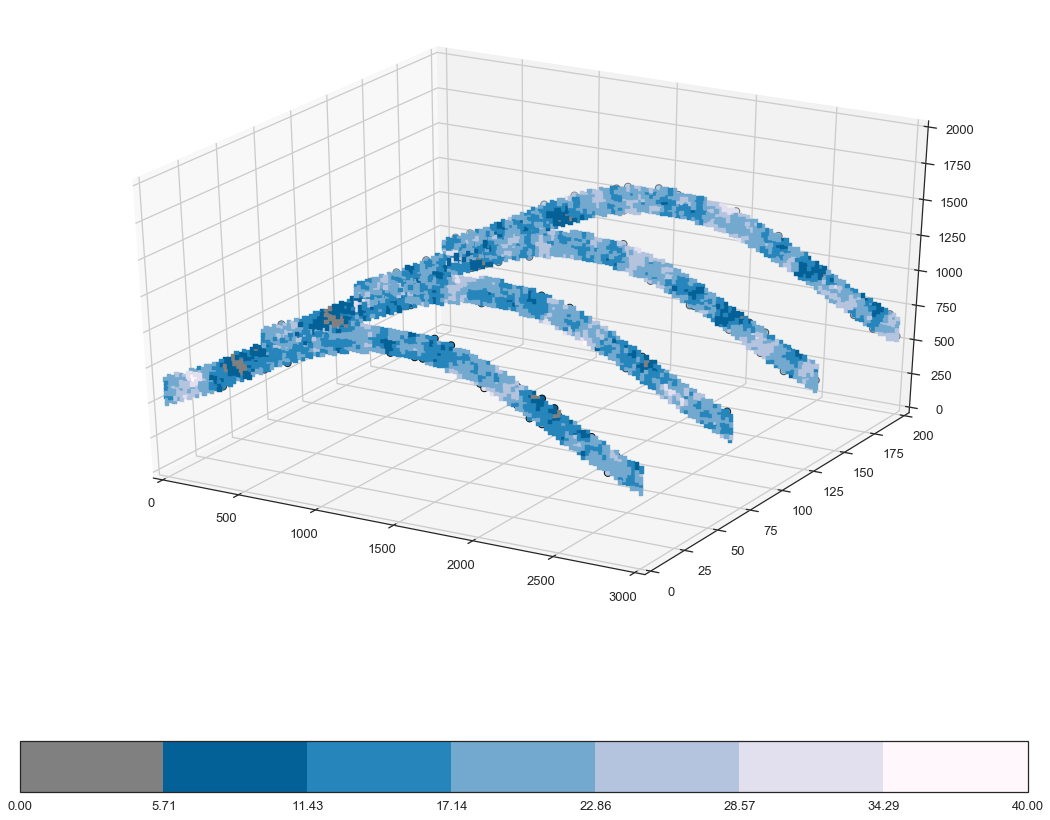

In [12]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=20, marker=',', cmap=cmap, norm=norm, alpha=1)
#b = ax.scatter3D(xs=test.result_coord[0][:200],ys=test.result_coord[1][:200],zs=test.result_coord[2][:200], c=test.kriging_result[1][:200], s=20 ,marker=',', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')
c = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')
#d = ax.scatter3D(xs=contr_coord[0],ys=contr_coord[1],zs=contr_coord[2], c='black', s=5, marker='o')

fig.colorbar(a, orientation='horizontal')

In [13]:
# test mit Störung
# Importing the data from CSV-files and setting extent and resolution
geo_data1 = gp.create_data([0,2000,0,2000,0,2000],[50,50,50], 
      path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_orientations.csv",
      path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_points.csv") 

# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data1, {"Fault_Series":'Main_Fault', 
                         "Strat_Series": ('Sandstone_2','Siltstone',
                                          'Shale', 'Sandstone_1')},
                       order_series = ["Fault_Series", 'Strat_Series'],
                       order_formations=['Main_Fault', 
                                         'Sandstone_2','Siltstone',
                                         'Shale', 'Sandstone_1',
                                         ], verbose=0) 

interp_data1 = gp.InterpolatorData(geo_data1,
                                  output='geology', compile_theano=True,
                                  theano_optimizer='fast_compile',
                                  verbose=[])

lith_block1, fault_block1 = gp.compute_model(interp_data1)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [14]:
test1 = Kriging(test_single, lith_block1, geo_data1.grid, formation_number=3, kriging_type='OK')

AttributeError: 'GridClass' object has no attribute 'grid'

In [ ]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,2000)
ax.axes.set_ylim3d(0,2000)
a = ax.scatter3D(xs=test1.result_coord[0],ys=test1.result_coord[1],zs=test1.result_coord[2], c=test1.kriging_result[1], s=20, marker=',', cmap=cmap, norm=norm, alpha=1)
#b = ax.scatter3D(xs=test.result_coord[0][:200],ys=test.result_coord[1][:200],zs=test.result_coord[2][:200], c=test.kriging_result[1][:200], s=20 ,marker=',', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')
#c = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

fig.colorbar(a, orientation='horizontal')